# Predicting survival time from data from the National Cancer Institute (Genomic Data Commons)

Find the dataset at: https://portal.gdc.cancer.gov/analysis_page?app=CDave

## 1. Importing libraries and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch
import itertools
from gpr_helper import GPRModel, actual_predicted_plot, distribution_plot, train_and_evaluate_gpr_model, grid_search_kernel_params
from sklearn.decomposition import PCA


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [2]:

# Define required attributes
required_attributes = {
    "primary_diagnosis",
    "case_id",
    "age_at_diagnosis",
    "gender",
    "race",
    "ethnicity",
    "age_at_index",
    "ajcc_pathologic_stage",
    "prior_malignancy",
    "prior_treatment",
    "classification_of_tumor",
    "metastasis_at_diagnosis",
    "tumor_grade",
    "progression_or_recurrence",
    "alcohol_history",
    "cigarettes_per_day",
    "years_smoked",
    "vital_status",
    "days_to_diagnosis",
    "days_to_last_follow_up",
    "days_to_treatment_start",
    "days_to_treatment_end",
    "days_to_recurrence",
    "days_to_death"
}

df = pd.read_csv("clinical_data_extracted.csv")

# Select only required attributes that exist in the dataset
df = df[list(required_attributes & set(df.columns))]

### 1.1 Preprocessing

In [3]:

target = "days_to_death"

# Drop rows where the target is missing
df = df.dropna(subset=[target])
print("dataset after dropna: ", len(df))

q_low = df[target].quantile(0.01)
q_hi  = df[target].quantile(0.99)

df_filtered = df[(df[target] < q_hi) & (df[target] > q_low)]

# Print final number of rows
print(f"Balanced dataset size (not used): {len(df_filtered)}")


# ------------ Separate features into different types for feature engineering

numerical_features = [
    "age_at_diagnosis", "age_at_index", "days_to_last_follow_up",
    "days_to_diagnosis", "days_to_treatment_start", "days_to_treatment_end", "days_to_recurrence", "cigarettes_per_day", "years_smoked"
]

# Features with arbitrary labels that can be one-hot encoded
categorical_label_features = [
    "primary_diagnosis", "classification_of_tumor", "gender", "race",
    "ethnicity", "prior_malignancy", "prior_treatment",
    "metastasis_at_diagnosis", "progression_or_recurrence", "alcohol_history"
]

categorical_order_features = [
    "tumor_grade", "ajcc_pathologic_stage"
]

# Remove columns that don't exist in dataframe
numerical_features = [col for col in numerical_features if col in df.columns]
categorical_label_features = [col for col in categorical_label_features if col in df.columns]
categorical_order_features = [col for col in categorical_order_features if col in df.columns]

# ------------ Define preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean', fill_value='Unknown')),  # Fill missing numerical values with mean
    # ('scaler', StandardScaler())  # Normalize numerical data
    ('scaler', RobustScaler())  # Normalize numerical data using RobustScaler for outliers
])

cat_label_pipeline = Pipeline([
    # ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing categorical values
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # Fill missing categorical values with Unknown since not being 
                                                      # able to find a categorical value can be a type of diagnosis itself 
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Convert categorical to one hot encoded vectors
])

cat_order_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant')),  # Fill missing orderly categorical values with Unknown
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Use ordinal encoding because tumor grades have levels
])

# Combine all the pipelines
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat_label', cat_label_pipeline, categorical_label_features),
    ('cat_order', cat_order_pipeline, categorical_order_features)
])

dataset after dropna:  6480
Balanced dataset size (not used): 6338


In [4]:
# Splitting dataset
X = df[numerical_features + categorical_label_features + categorical_order_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.2 Check correlation between numeric columns

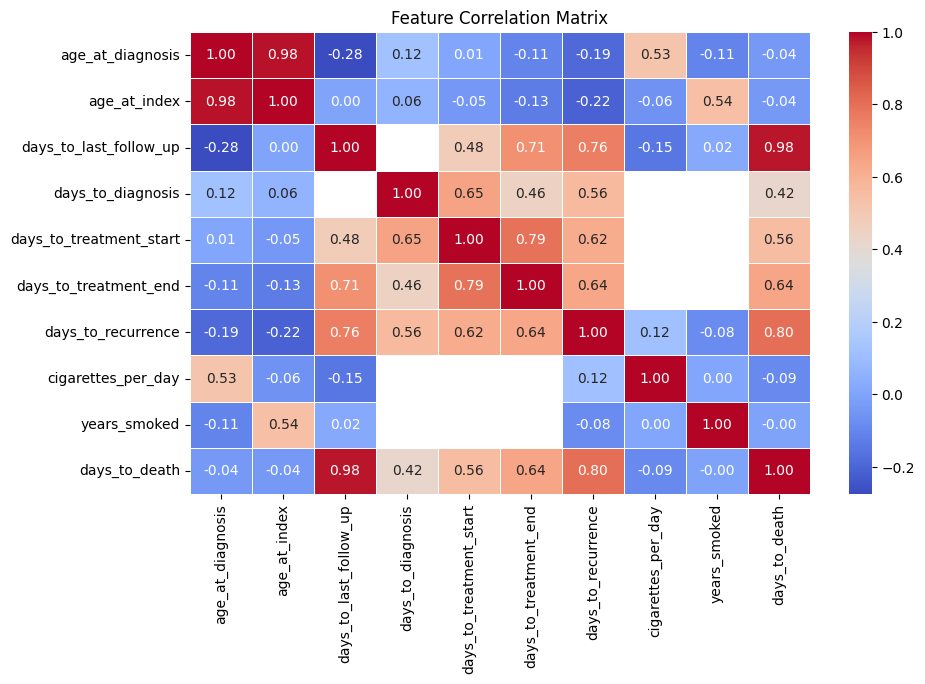

Feature Correlations with Target:
 years_smoked               0.002529
age_at_diagnosis           0.036285
age_at_index               0.037510
cigarettes_per_day         0.089113
days_to_diagnosis          0.418756
days_to_treatment_start    0.555428
days_to_treatment_end      0.641441
days_to_recurrence         0.804851
days_to_last_follow_up     0.979731
days_to_death              1.000000
Name: days_to_death, dtype: float64


In [5]:
# Compute correlation matrix for numerical columns
correlation_matrix = df[numerical_features + [target]].corr()

# Visualize correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify features with low correlation to the target
low_corr_features = correlation_matrix[target].abs().sort_values()
print("Feature Correlations with Target:\n", low_corr_features)

### 1.3 PCA - Remove features that don't contribute much to the data variation

Original number of features excluding target (days_to_death): 23
Remaining features after variance thresholding: (21,)
Removed features in variance thresholding: {'case_id', 'vital_status'}


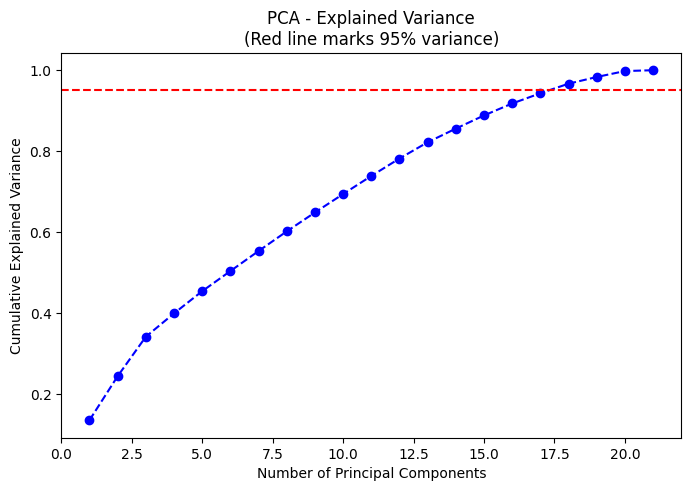

Removed features after PCA: set()
Length of loadings:  21
Shape of loadings:  (18, 21)
Length of high variance:  21
Top contributing features to the first few principal components:

prior_malignancy             0.195372
ajcc_pathologic_stage        0.195311
prior_treatment              0.190410
alcohol_history              0.185998
days_to_recurrence           0.185976
ethnicity                    0.184062
race                         0.183466
classification_of_tumor      0.183184
primary_diagnosis            0.182646
gender                       0.181188
days_to_diagnosis            0.173142
cigarettes_per_day           0.172695
tumor_grade                  0.164947
days_to_treatment_end        0.161649
days_to_last_follow_up       0.154537
metastasis_at_diagnosis      0.146804
years_smoked                 0.125600
age_at_diagnosis             0.119885
age_at_index                 0.117741
progression_or_recurrence    0.112382
days_to_treatment_start      0.094346
dtype: float64


In [6]:
df_pca = df.copy()
df_pca.drop('days_to_death', axis=1, inplace=True)

# Fill missing values: Mean for numerical, Most frequent for categorical
for col in numerical_features:
    df_pca[col] = df_pca[col].fillna(df_pca[col].mean())

for col in categorical_label_features + categorical_order_features:
    df_pca[col] = df_pca[col].fillna(df_pca[col].mode()[0])

# Encode categorical features
for col in categorical_label_features + categorical_order_features:
    df_pca[col] = LabelEncoder().fit_transform(df_pca[col].astype(str))

# Combine numerical and categorical features
X_pca = df_pca[numerical_features + categorical_label_features + categorical_order_features]

# Drop low-variance features before PCA
variance_threshold = 0.01 
feature_variance = X_pca.var()
high_variance_features = feature_variance[feature_variance > variance_threshold].index

print("Original number of features excluding target (days_to_death):", df.shape[1] - 1)
print("Remaining features after variance thresholding:", high_variance_features.shape)
print("Removed features in variance thresholding:", set(df_pca.columns.tolist()) - set(high_variance_features))


# Plot a graph to show how many features represent 95% of variatiance

# Standardize the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

# Apply PCA
pca = PCA(n_components=len(X_pca.columns))  # Set to maximum possible components
X_pca_transformed = pca.fit_transform(X_scaled)

# Explained Variance Ratio
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance\n(Red line marks 95% variance)')
plt.axhline(y=0.95, color='r', linestyle='--')  # Mark 95% threshold
plt.show()

# Refit PCA to only include columns that represent 95% of variance

X_pca = X_pca[high_variance_features]

# Standardize the features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=0.95)  # Keep enough components to retain 95% variance
X_pca_transformed = pca.fit_transform(X_scaled)

# Print removed features after PCA (if any)
print("Removed features after PCA:", set(high_variance_features) - set(X_pca.columns.tolist()))

# Explained Variance Ratio Plot
explained_variance = np.cumsum(pca.explained_variance_ratio_)
num_components_95 = np.argmax(explained_variance >= 0.95) + 1

# Display feature importance in PCA
loadings = pd.DataFrame(pca.components_, columns=X_pca.columns, index=[f'PC{i+1}' for i in range(pca.n_components_)])

print("Length of loadings: ", len(loadings.columns.tolist()))
print("Shape of loadings: ", loadings.shape)
print("Length of high variance: ", len(high_variance_features))
print("Top contributing features to the first few principal components:\n")
# print(loadings.abs().mean().sort_values(ascending=False).head(2))
print(loadings.abs().mean().sort_values(ascending=False))

## 2. Linear Regression with multiple dependent columns

### 2.1 Model training and plotting without k-folds and without PCA

MSE: 399077.71
MAE: 405.25
RMSE: 631.7260
R² Score: 0.4091


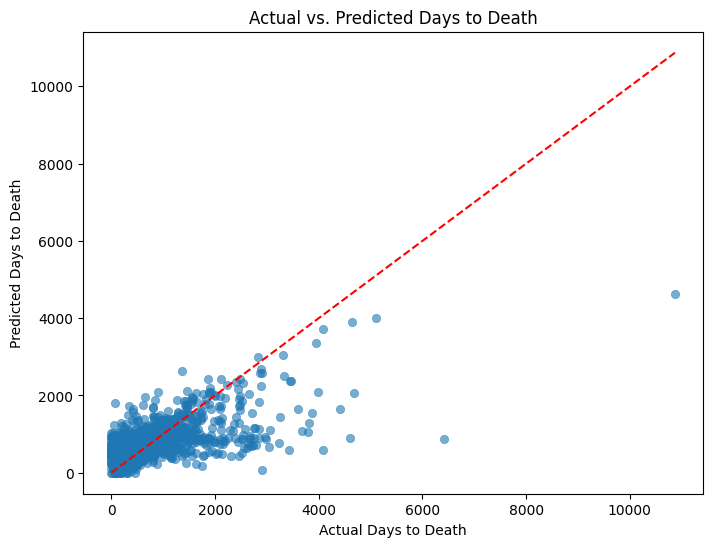

In [7]:
# Define model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Ensure non-negative predictions (clip negative values to 0)
# Compares each element in y_pred to 0 and if it's negative, return 0
y_pred = np.maximum(0, y_pred)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {np.sqrt(mse):.4f}")
print(f"R² Score: {r2:.4f}")

# Ploting the Actual vs Predictied Days to Death

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)  # Plots Actual vs. Predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # Red line represents the ideal case
plt.xlabel("Actual Days to Death")
plt.ylabel("Predicted Days to Death")
plt.title("Actual vs. Predicted Days to Death")
plt.show()

### 2.2 Model training and plotting with k-folds but without PCA

Average Mean Absolute Error (MAE): 407.8855
Average Mean Squared Error (MSE): 403303.2988
Average Root Mean Squared Error (RMSE): 634.5274
Average R² Score: 0.4191


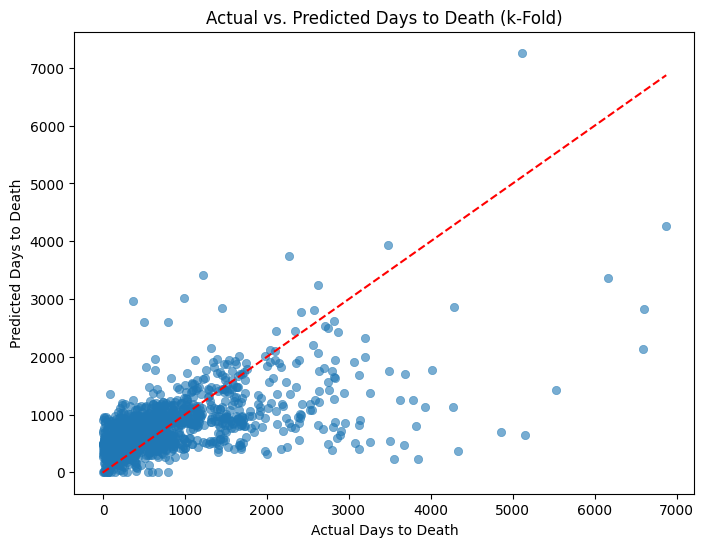

In [8]:
# Define model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Initialize k-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
mse_scores = []
rmse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Ensure using iloc for DataFrame indexing
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model pipeline
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Ensure non-negative predictions (clip negative values to 0)
    y_pred = np.maximum(0, y_pred)

    # Evaluate performance
    r2_scores.append(r2_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))


# Print average scores
print(f'Average Mean Absolute Error (MAE): {np.mean(mae_scores):.4f}')
print(f'Average Mean Squared Error (MSE): {np.mean(mse_scores):.4f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_scores):.4f}')
print(f'Average R² Score: {np.mean(r2_scores):.4f}')

# Plots

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)  # Plots Actual vs. Predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # Red line represents the ideal case
plt.xlabel("Actual Days to Death")
plt.ylabel("Predicted Days to Death")
plt.title("Actual vs. Predicted Days to Death (k-Fold)")
plt.show()

### 2.3 Model training and plotting with k-folds and with PCA

Average Mean Absolute Error (MAE): 438.8584
Average Mean Squared Error (MSE): 440689.9424
Average Root Mean Squared Error (RMSE): 663.2632
Average R² Score: 0.3649


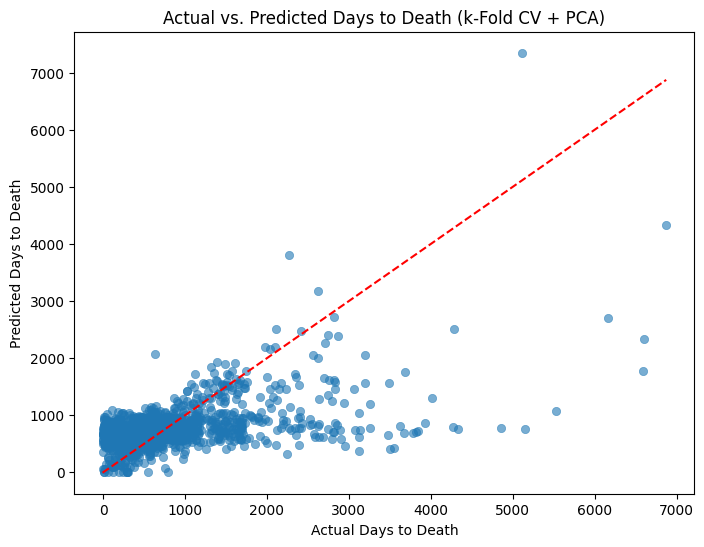

In [10]:
# Initialize k-Fold Cross-Validation
kf = KFold(n_splits = 5, shuffle=True, random_state=42)

r2_scores = []
mse_scores = []
rmse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X_pca_transformed):
    X_train, X_test = X_pca_transformed[train_index], X_pca_transformed[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Ensure non-negative predictions (clip negative values to 0)
    y_pred = np.maximum(0, y_pred)

    # Evaluate performance
    r2_scores.append(r2_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

# Print average scores
print(f'Average Mean Absolute Error (MAE): {np.mean(mae_scores):.4f}')
print(f'Average Mean Squared Error (MSE): {np.mean(mse_scores):.4f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_scores):.4f}')
print(f'Average R² Score: {np.mean(r2_scores):.4f}')

# ------------ Plots

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)  # Plots Actual vs. Predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')  # Red line represents the ideal case
plt.xlabel("Actual Days to Death")
plt.ylabel("Predicted Days to Death")
plt.title("Actual vs. Predicted Days to Death (k-Fold CV + PCA)")
plt.show()


## 3. Gaussian Process Regression (GPR)

Total Paramter combinations in param_grid: 196
Trying kernel type: rbf_matern with parameters: {'lengthscale': 9.999999999999999e-06, 'variance': 0.001} noise - 0.01
Using device: cuda
Iteration 1/100 - Loss: 1433588.25
Iteration 21/100 - Loss: 854241.3125
Iteration 41/100 - Loss: 781726.0
Early stopping
MSE: 1081256.5, MAE: 680.760498046875, R2: -0.6008586883544922, RMSE: 1039.8348426553132
Trying kernel type: rbf_matern with parameters: {'lengthscale': 9.999999999999999e-06, 'variance': 0.001} noise - 0.021544346900318832
Using device: cuda
Iteration 1/100 - Loss: 1543156.25
Iteration 21/100 - Loss: 854412.125
Early stopping
MSE: 1084352.625, MAE: 681.941162109375, R2: -0.6054426431655884, RMSE: 1041.3225364890554
Trying kernel type: rbf_matern with parameters: {'lengthscale': 9.999999999999999e-06, 'variance': 0.001} noise - 0.046415888336127774
Using device: cuda
Iteration 1/100 - Loss: 1433588.25
Iteration 21/100 - Loss: 885252.625
Iteration 41/100 - Loss: 850967.125
Early stoppin

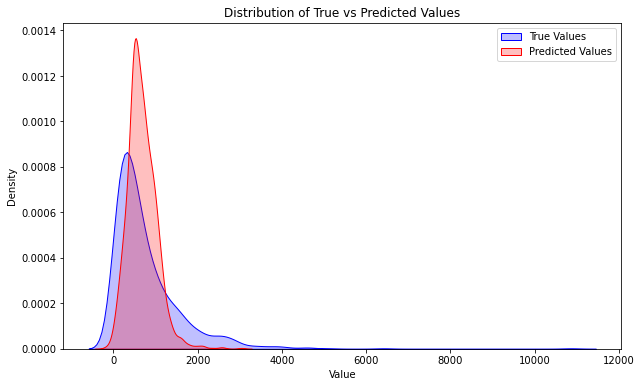

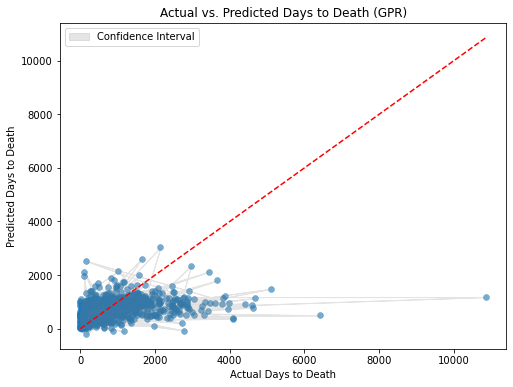

Kernel: rq - Paramter - {'lengthscale': 0.021544346900318843, 'variance': 0.09999999999999999, 'noise': 0.01} - MSE: 570899.625, MAE: 450.27294921875, R2: 0.1547521948814392, RMSE: 755.5789998405196


In [ ]:
# Kernel Paramters combinations
lengthscales = np.logspace(-5, 0, 7)
variances = np.logspace(-3, 1, 7)
noises = np.logspace(-2, -1, 4) 

param_grid = [
    {
        'lengthscale': ls,
        'variance': var,
        'noise': noise
    }
    for ls, var, noise in itertools.product(lengthscales, variances, noises)
]

total_combinations = len(param_grid)
print(f"Total Paramter combinations in param_grid: {total_combinations}")

# Preprocess the features (this will apply transformations to all the data)
X_preprocessed = preprocessor.fit_transform(X)
y_preprocessed = y.values 

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

# Convert the preprocessed data into torch tensors
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)
test_y = torch.tensor(y_test, dtype=torch.float32)

# Define the kernel types for the model
kernel_types = ['rbf_matern', 'rbf_rq', 'matern_rq', 'rq', 'matern', 'rbf'] 

# Grid search for best kernel parameters
y_pred, lower, upper, best_kernel_type, best_kernel_params, mse, mae, r2 = grid_search_kernel_params(kernel_types, train_x, train_y, test_x, test_y, param_grid)
torch.cuda.empty_cache()

# Plot the combined plot of True vs Predicted values with confidence intervals
distribution_plot(test_y.numpy(), y_pred.numpy())
actual_predicted_plot(test_y.numpy(), y_pred.numpy(), lower.numpy(), upper.numpy())

print(f"Kernel: {best_kernel_type} - Paramter - {best_kernel_params} - MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {np.sqrt(mse)}")
